## Commit

In [187]:
!./build_commit.sh

"docker kill" requires at least 1 argument.
See 'docker kill --help'.

Usage:  docker kill [OPTIONS] CONTAINER [CONTAINER...]

Kill one or more running containers
Creating flash-attention_flashattention_run ... 
ting flash-attention_flashattention_run ... done
== PyTorch ==

NVIDIA Release 22.12 (build 49968248)
PyTorch Version 1.14.0a0+410ce96

Container image Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Copyright (c) 2014-2022 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, J

byte-compiling build/bdist.linux-x86_64/egg/flash_attn/losses/__init__.py to __init__.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/losses/cross_entropy.py to cross_entropy.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/flash_attn_triton_onewritehead.py to flash_attn_triton_onewritehead.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/flash_attn_triton_og.py to flash_attn_triton_og.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/flash_attn_interface.py to flash_attn_interface.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/layers/patch_embed.py to patch_embed.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/layers/__init__.py to __init__.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/layers/rotary.py to rotary.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/flash_blocksparse_attn_interface.py to flash_blockspar

## Benchmark automation

In [2]:
#!echo "PYTHONPATH=$PWD python3 benchmarks/benchmark_flash_attention.py"  | docker-compose run flashattention > bench_flash_attention.log

Creating flash-attention_flashattention_run ... 
ting flash-attention_flashattention_run ... done

In [185]:
#!echo "PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py"  | docker-compose run flashattention > bench_causal.log

Creating flash-attention_flashattention_run ... 
ting flash-attention_flashattention_run ... doneSTAGE:2023-05-06 18:06:06 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:06:06 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-06 18:06:09 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:06:09 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [199]:
import os

def parse_causal_benchmark(fn="bench_causal.log"):
    causal_data={}
    with open("bench_causal.log","r") as fp:
        att_type=""
        pass_dir=""
        bypass=0
        time_str=""
        for ln in fp:
            #print(ln)        
            if bypass >1:
                #print("<pass",bypass,">")            
                bypass-=1 #Ignore lines until bypass==1
            elif bypass == 1:
                #Collect runtime measurement
                #print("record")
                time_str=ln.split()[0]
                time_float=float(time_str)
                unit_str=ln.split()[1]
                if "us" in unit_str:
                    #print("Detected us in line:",ln,"att_type:",att_type,"pass_dir:",pass_dir)
                    time_float *= 0.001 # us to ms
                    #print("Resolved to",time_float,"ms")
                causal_data[att_type+pass_dir]=time_float
                bypass=0
                #print(float(time_str))
            else:
                if "MaxMemory" in ln:
                    # Assume attention type has already been determined
                    mem_str=ln.split(":")[1].split("GB")[0]
                    mem_float=float(mem_str)
                    causal_data[att_type+pass_dir+"MaxMemory"]=mem_float
                elif "FlashAttention Triton OWH" in ln:
                    #print("FlashAttention triton owh")
                    # Identify attention type and direction for experiment
                    att_type="FlashAttention Triton OWH"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3            
                elif "FlashAttention Triton OG" in ln:
                    #print("FlashAttention triton og")
                    # Identify attention type and direction for experiment
                    att_type="FlashAttention Triton OG"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3
                elif "FlashAttention Triton" in ln:
                    #print("FlashAttention triton")
                    # Identify attention type and direction for experiment
                    att_type="FlashAttention Triton"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3                
                    #print(att_type)
                    #print(pass_dir)
                elif "FlashAttention" in ln:
                    # Identify attention type and direction for experiment
                    att_type="FlashAttention"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3
                    #print(att_type)
                    #print(pass_dir)
                if "PyTorch Attention" in ln:
                    # Identify attention type and direction for experiment
                    att_type="StandardAttention"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3
                    #print(att_type)
                    #print(pass_dir)
    return causal_data

def benchmark_causal(cfg={},fn="bench_causal.log"):
    opts=" "
    if "repeats" in cfg:
        opts += " -r " + str(cfg["repeats"])
    if "batch_size" in cfg:
        opts += " -b " + str(cfg["batch_size"])
    if "seqlen" in cfg:
        opts += " -m " + str(cfg["seqlen"])
    if "nheads" in cfg:
        opts += " -e " + str(cfg["nheads"])
    if "headdim" in cfg:
        opts += " -k " + str(cfg["headdim"])
    opts += " "
    
    base_cmd="echo \"PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py\""
    env=" | docker-compose run flashattention "
    outp= " > " + fn
 
    cmd=base_cmd + opts + env + outp
    print(cmd)
    os.system(cmd)
    causal_data=parse_causal_benchmark(fn)
    print(causal_data)
    return causal_data

In [200]:
benchmark_causal()

echo "PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py"   | docker-compose run flashattention  > bench_causal.log


Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-06 18:32:17 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:32:17 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-06 18:32:20 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:32:20 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 1.81, 'FlashAttentionBackward pass': 5.28, 'FlashAttentionForward + Backward pass': 7.22, 'FlashAttentionForward + Backward passMaxMemory': 0.5780009765625, 'StandardAttentionForward pass': 10.0, 'StandardAttentionBackward pass': 15.18, 'StandardAttentionForward + Backward pass': 25.29, 'StandardAttentionForward + Backward passMaxMemory': 2.70000048828125, 'FlashAttention TritonForward pass': 1.34, 'FlashAttention TritonBackward pass': 5.39, 'FlashAttention TritonForward + Backward pass': 6.93, 'FlashAttention TritonForward + Backward passMaxMemory': 0.65600048828125, 'FlashAttention Triton OWHForward pass': 1.27, 'FlashAttention Triton OWHBackward pass': 5.37, 'FlashAttention Triton OWHForward + Backward pass': 6.81, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 1.04800048828125}


{'FlashAttentionForward pass': 1.81,
 'FlashAttentionBackward pass': 5.28,
 'FlashAttentionForward + Backward pass': 7.22,
 'FlashAttentionForward + Backward passMaxMemory': 0.5780009765625,
 'StandardAttentionForward pass': 10.0,
 'StandardAttentionBackward pass': 15.18,
 'StandardAttentionForward + Backward pass': 25.29,
 'StandardAttentionForward + Backward passMaxMemory': 2.70000048828125,
 'FlashAttention TritonForward pass': 1.34,
 'FlashAttention TritonBackward pass': 5.39,
 'FlashAttention TritonForward + Backward pass': 6.93,
 'FlashAttention TritonForward + Backward passMaxMemory': 0.65600048828125,
 'FlashAttention Triton OWHForward pass': 1.27,
 'FlashAttention Triton OWHBackward pass': 5.37,
 'FlashAttention Triton OWHForward + Backward pass': 6.81,
 'FlashAttention Triton OWHForward + Backward passMaxMemory': 1.04800048828125}

In [198]:
!cat bench_causal.log


== PyTorch ==

NVIDIA Release 22.12 (build 49968248)
PyTorch Version 1.14.0a0+410ce96

Container image Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Copyright (c) 2014-2022 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This 

noncausal_data={}
with open("bench_flash_attention.log","r") as fp:
    att_type=""
    pass_dir=""
    bypass=0
    time_str=""
    for ln in fp:
        if bypass >1:
            #print("<pass",bypass,">")            
            bypass-=1 #Ignore lines until bypass==1
        elif bypass == 1:
            #Collect runtime measurement
            time_str=ln.split()[0]
            noncausal_data[att_type+pass_dir]=float(time_str)
            bypass=0
            #print(float(time_str))
        else:
            if "FlashAttention" in ln:
                # Identify attention type and direction for experiment
                att_type="FlashAttention"
                pass_dir=ln.split("-")[1][1:].strip()
                bypass=3
                #print(att_type)
                #print(pass_dir)
            if "PyTorch Standard Attention" in ln:
                # Identify attention type and direction for experiment
                att_type="StandardAttention"
                pass_dir=ln.split("-")[1][1:].strip()
                bypass=3
                #print(att_type)
                #print(pass_dir)   
                
causal_data={}
with open("bench_causal.log","r") as fp:
    att_type=""
    pass_dir=""
    bypass=0
    time_str=""
    for ln in fp:
        print(ln)        
        if bypass >1:
            #print("<pass",bypass,">")            
            bypass-=1 #Ignore lines until bypass==1
        elif bypass == 1:
            #Collect runtime measurement
            print("record")
            time_str=ln.split()[0]
            causal_data[att_type+pass_dir]=float(time_str)
            bypass=0
            #print(float(time_str))
        else:
            if "FlashAttention Triton OWH" in ln:
                print("FlashAttention triton owh")
                # Identify attention type and direction for experiment
                att_type="FlashAttention Triton OWH"
                pass_dir=ln.split("-")[1][1:].strip()
                bypass=3            
            elif "FlashAttention Triton OG" in ln:
                print("FlashAttention triton og")
                # Identify attention type and direction for experiment
                att_type="FlashAttention Triton OG"
                pass_dir=ln.split("-")[1][1:].strip()
                bypass=3
            elif "FlashAttention Triton" in ln:
                print("FlashAttention triton")
                # Identify attention type and direction for experiment
                att_type="FlashAttention Triton"
                pass_dir=ln.split("-")[1][1:].strip()
                bypass=3                
                #print(att_type)
                #print(pass_dir)
            elif "FlashAttention" in ln:
                # Identify attention type and direction for experiment
                att_type="FlashAttention"
                pass_dir=ln.split("-")[1][1:].strip()
                bypass=3
                #print(att_type)
                #print(pass_dir)
            if "PyTorch Attention" in ln:
                # Identify attention type and direction for experiment
                att_type="StandardAttention"
                pass_dir=ln.split("-")[1][1:].strip()
                bypass=3
                #print(att_type)
                #print(pass_dir)                   

## Sweep

### RTX 3090 speedup & memory vs sequence length

* batch_size=12
* nheads=12
* From A100 result - headdim=64
* seqlen = 128 - 4096
* Keep repeats=30

Authors' note: "Memory savings are the same as on an A100", "We see slightly higher speedups (between 2.5-4.5x) on the GTX 3090, since memory bandwidth on the GDDR6X is lower than A100 HBM (~900 GB/s vs. ~1.5 TB/s)."

In [205]:
import matplotlib.pyplot as plt

cfg={}
cfg["batch_size"]=12
cfg["nheads"]=12
cfg["headdim"]=64


seqlen=[128,256,512,1024,2048] #4096 exceeds 3090 24GB memory

res=[]

for sl in seqlen:
    print("seqlen=",sl)
    cfg["seqlen"]=sl
    print("cfg:",cfg)
    res.append(benchmark_causal(cfg))

seqlen= 128
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen': 128}
echo "PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py"  -b 12 -m 128 -e 12 -k 64  | docker-compose run flashattention  > bench_causal.log


Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-06 18:36:39 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:36:39 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-06 18:36:42 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:36:42 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 0.05671, 'FlashAttentionBackward pass': 0.09465000000000001, 'FlashAttentionForward + Backward pass': 0.21423, 'FlashAttentionForward + Backward passMaxMemory': 0.0158212890625, 'StandardAttentionForward pass': 0.25242, 'StandardAttentionBackward pass': 0.60793, 'StandardAttentionForward + Backward pass': 0.7423, 'StandardAttentionForward + Backward passMaxMemory': 0.03956298828125, 'FlashAttention TritonForward pass': 0.10513, 'FlashAttention TritonBackward pass': 0.5881900000000001, 'FlashAttention TritonForward + Backward pass': 0.38383, 'FlashAttention TritonForward + Backward passMaxMemory': 0.03078173828125, 'FlashAttention Triton OWHForward pass': 0.11504, 'FlashAttention Triton OWHBackward pass': 0.29727, 'FlashAttention Triton OWHForward + Backward pass': 0.53289, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.04517236328125}
seqlen= 256
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen': 256}
echo "PYTHONPATH=$PWD pyth

Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-06 18:36:51 99:99 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:36:51 99:99 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-06 18:36:54 99:99 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:36:54 99:99 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 0.12058, 'FlashAttentionBackward pass': 0.21087, 'FlashAttentionForward + Backward pass': 0.3488, 'FlashAttentionForward + Backward passMaxMemory': 0.0326416015625, 'StandardAttentionForward pass': 0.26092000000000004, 'StandardAttentionBackward pass': 0.44479, 'StandardAttentionForward + Backward pass': 0.7203700000000001, 'StandardAttentionForward + Backward passMaxMemory': 0.09025048828125, 'FlashAttention TritonForward pass': 0.10743000000000001, 'FlashAttention TritonBackward pass': 0.55261, 'FlashAttention TritonForward + Backward pass': 0.43563999999999997, 'FlashAttention TritonForward + Backward passMaxMemory': 0.05406298828125, 'FlashAttention Triton OWHForward pass': 0.1172, 'FlashAttention Triton OWHBackward pass': 0.5846, 'FlashAttention Triton OWHForward + Backward pass': 0.7949700000000001, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.08284423828125}
seqlen= 512
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen'

Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-06 18:37:02 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:37:02 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-06 18:37:05 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:37:05 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 0.2635, 'FlashAttentionBackward pass': 0.55306, 'FlashAttentionForward + Backward pass': 0.84092, 'FlashAttentionForward + Backward passMaxMemory': 0.0832822265625, 'StandardAttentionForward pass': 0.7543099999999999, 'StandardAttentionBackward pass': 1.3, 'StandardAttentionForward + Backward pass': 2.06, 'StandardAttentionForward + Backward passMaxMemory': 0.24500048828125, 'FlashAttention TritonForward pass': 0.12693000000000002, 'FlashAttention TritonBackward pass': 0.54689, 'FlashAttention TritonForward + Backward pass': 0.68929, 'FlashAttention TritonForward + Backward passMaxMemory': 0.10112548828125, 'FlashAttention Triton OWHForward pass': 0.12390000000000001, 'FlashAttention Triton OWHBackward pass': 0.6951200000000001, 'FlashAttention Triton OWHForward + Backward pass': 0.78003, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.15868798828125}
seqlen= 1024
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen': 1024}
echo "PY

Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-06 18:37:15 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:37:15 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-06 18:37:17 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:37:17 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 0.6517200000000001, 'FlashAttentionBackward pass': 1.69, 'FlashAttentionForward + Backward pass': 2.25, 'FlashAttentionForward + Backward passMaxMemory': 0.1625634765625, 'StandardAttentionForward pass': 2.86, 'StandardAttentionBackward pass': 4.3, 'StandardAttentionForward + Backward pass': 7.2, 'StandardAttentionForward + Backward passMaxMemory': 0.76800048828125, 'FlashAttention TritonForward pass': 0.37269, 'FlashAttention TritonBackward pass': 1.53, 'FlashAttention TritonForward + Backward pass': 1.95, 'FlashAttention TritonForward + Backward passMaxMemory': 0.19025048828125, 'FlashAttention Triton OWHForward pass': 0.36845, 'FlashAttention Triton OWHBackward pass': 1.58, 'FlashAttention Triton OWHForward + Backward pass': 2.01, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.30537548828125}
seqlen= 2048
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen': 2048}
echo "PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py"  -

Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-06 18:37:31 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:37:31 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-06 18:37:34 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-06 18:37:34 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 1.92, 'FlashAttentionBackward pass': 4.55, 'FlashAttentionForward + Backward pass': 6.58, 'FlashAttentionForward + Backward passMaxMemory': 0.3251259765625, 'StandardAttentionForward pass': 12.01, 'StandardAttentionBackward pass': 16.88, 'StandardAttentionForward + Backward pass': 29.02, 'StandardAttentionForward + Backward passMaxMemory': 2.68800048828125, 'FlashAttention TritonForward pass': 1.37, 'FlashAttention TritonBackward pass': 4.82, 'FlashAttention TritonForward + Backward pass': 6.27, 'FlashAttention TritonForward + Backward passMaxMemory': 0.37250048828125, 'FlashAttention Triton OWHForward pass': 1.35, 'FlashAttention Triton OWHBackward pass': 5.06, 'FlashAttention Triton OWHForward + Backward pass': 6.51, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.60375048828125}


In [207]:
import pickle

dat={"res":res}
with open("rtx_3090_sweep.p","wb") as fp:
    pickle.dump(dat,fp)

## Perf benchmark result

In [8]:
#data

4.422317138280833
2.3077163264509584
1.1531380426726996
0.9170945076080718
0.9692627989705087


Text(0.5, 1.0, 'NVIDIA RTX 3090 FlashAttention speedup, headdim 64')

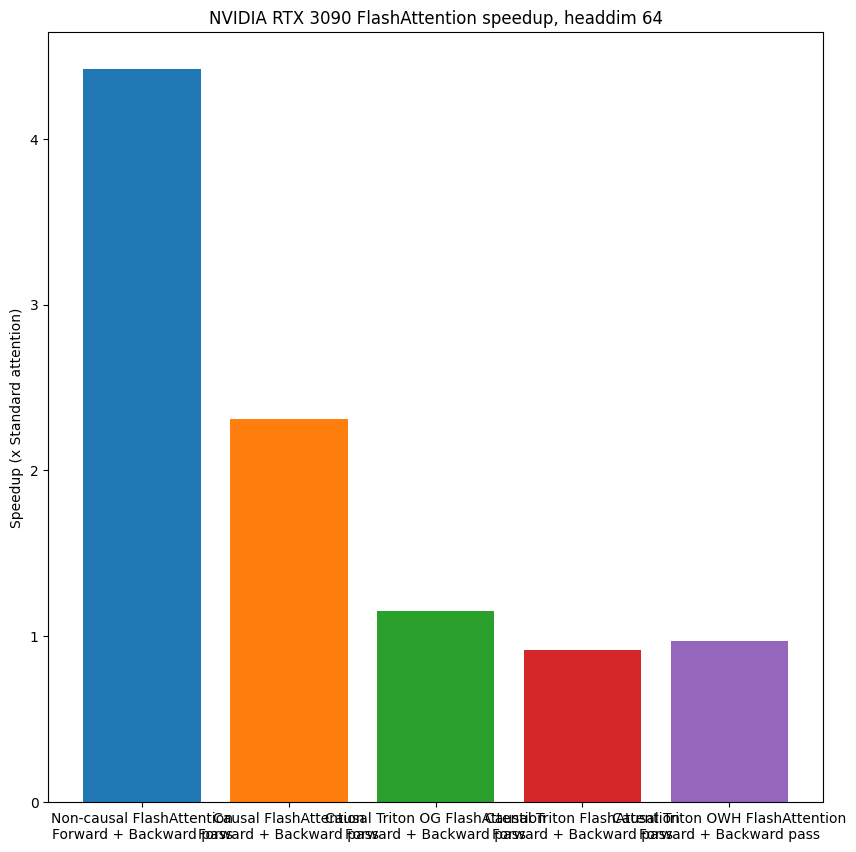

In [145]:
import matplotlib.pyplot as plt

xlabels=["Non-causal FlashAttention\nForward + Backward pass","Causal FlashAttention\nForward + Backward pass","Causal Triton OG FlashAttention\nForward + Backward pass","Causal Triton FlashAttention\nForward + Backward pass","Causal Triton OWH FlashAttention\nForward + Backward pass"]

noncausal_baseline=noncausal_data["StandardAttentionForward + Backward pass"]
noncausal_yheights=[noncausal_baseline/noncausal_data["FlashAttentionForward + Backward pass"]]
print(noncausal_baseline/noncausal_data["FlashAttentionForward + Backward pass"])

causal_baseline=causal_data["StandardAttentionForward + Backward pass"]
causal_yheights=[causal_baseline/causal_data["FlashAttentionForward + Backward pass"]]
print(causal_baseline/causal_data["FlashAttentionForward + Backward pass"])

causal_tritonOG_baseline=causal_data["StandardAttentionForward + Backward pass"]
causal_tritonOG_yheights=[causal_tritonOG_baseline/causal_data["FlashAttention Triton OGForward + Backward pass"]]
print(causal_tritonOG_baseline/causal_data["FlashAttention Triton OGForward + Backward pass"])

causal_triton_baseline=causal_data["StandardAttentionForward + Backward pass"]
causal_triton_yheights=[causal_triton_baseline/causal_data["FlashAttention TritonForward + Backward pass"]]
print(causal_triton_baseline/causal_data["FlashAttention TritonForward + Backward pass"])

causal_tritonOWH_baseline=causal_data["StandardAttentionForward + Backward pass"]
causal_tritonOWH_yheights=[causal_tritonOWH_baseline/causal_data["FlashAttention Triton OWHForward + Backward pass"]]
print(causal_tritonOWH_baseline/causal_data["FlashAttention Triton OWHForward + Backward pass"])

plt.figure(figsize=(10,10))
plt.bar(xlabels[0],noncausal_yheights)
plt.bar(xlabels[1],causal_yheights)
plt.bar(xlabels[2],causal_tritonOG_yheights)
plt.bar(xlabels[3],causal_triton_yheights)
plt.bar(xlabels[4],causal_tritonOWH_yheights)
plt.ylabel("Speedup (x Standard attention)")
plt.title("NVIDIA RTX 3090 FlashAttention speedup, headdim 64")

Text(0.5, 1.0, 'NVIDIA RTX 3090 FlashAttention execution time, headdim 64')

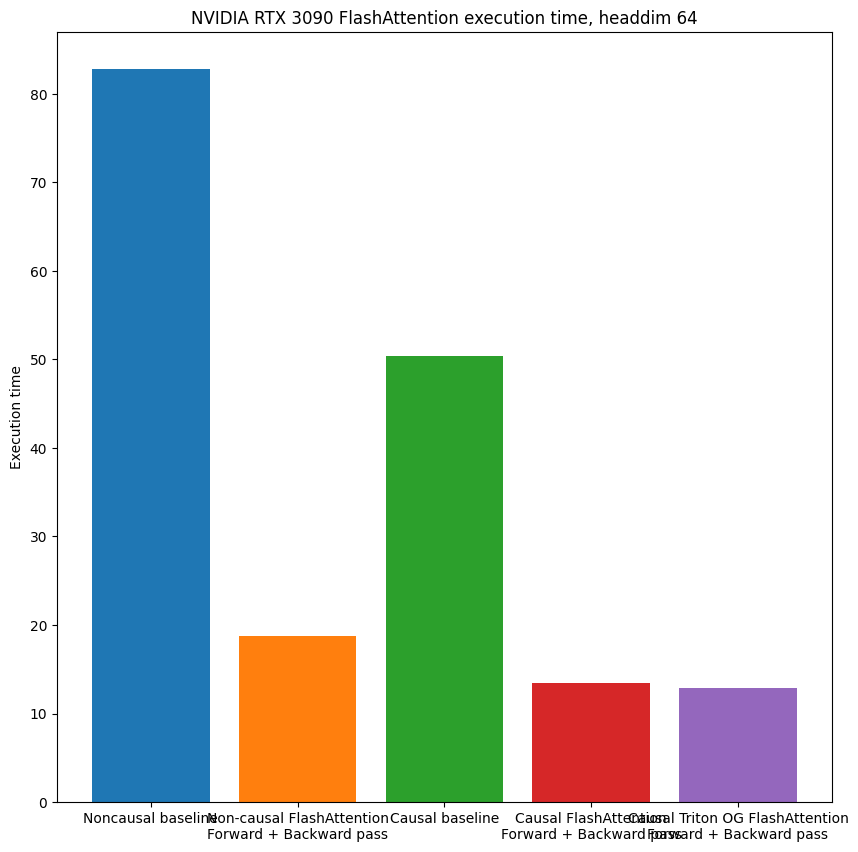

In [10]:
plt.figure(figsize=(10,10))
plt.bar("Noncausal baseline",noncausal_baseline)
plt.bar(xlabels[0],noncausal_data["FlashAttentionForward + Backward pass"])
plt.bar("Causal baseline",causal_baseline)
plt.bar(xlabels[1],causal_data["FlashAttentionForward + Backward pass"])
plt.bar(xlabels[2],causal_data["FlashAttention Triton OGForward + Backward pass"])
plt.ylabel("Execution time")
plt.title("NVIDIA RTX 3090 FlashAttention execution time, headdim 64")

In [126]:
!echo "pytest tests/test_flash_attn_onewritehead.py"  | docker-compose run flashattention

Creating flash-attention_flashattention_run ... 
ting flash-attention_flashattention_run ... done
== PyTorch ==

NVIDIA Release 22.12 (build 49968248)
PyTorch Version 1.14.0a0+410ce96

Container image Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Copyright (c) 2014-2022 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

Vari